**This notebook deals with all Analyses (so far) carried out with the Pangea dataset. The only exception is the tuning for DBSCAN and HDBSCAN which is done in Scatterplot-ClusteringTuning. Sections and subsections are denoted by mardown titles.**

### Data Load

In [1]:
%pylab inline
import umap

Populating the interactive namespace from numpy and matplotlib


In [2]:
#So far the data is divided in an initial set and a series of additionla batches of data (so far one).

#ids will save the ids of the sample (SRAs), projects will save the bioproject identifiers (PJRNA). SRRs will save
#the SRR (run) identifier.
ids=[]
projects=[]
SRRs=[]

#The ids and corresponding project of the first batch is loaded first from Proj_UID. Proj_UID was generated
#in the ProjectMatch notebook. in the Match folder.

FirstBatch=open("Proj_UID.csv","r")

for line in FirstBatch:
    line=line.strip("\n").split(";")
    ids.append(line[0])
    projects.append(line[1])
    SRRs.append(line[2])

In [3]:
#The second batch is loaded in the same way. Proj_UIDBatch2 was generated
#in the CheckforNew notebook in the Distances folder.
SecondBatch=open("Proj_UIDBatch2.csv","r")

for line in SecondBatch:
    line=line.strip("\n").split(";")
    
    if line[0] in ids:
        continue
    else:
        ids.append(line[0])
    projects.append(line[1])
    SRRs.append(line[2])

In [5]:
#Now we load the Mash distances. Here they are loaded in the tabular output format of Mash Triangle 
#generated with the -E flag (if I'm not wrong).
phy=open("NewDistances.tab","r")

#The distances are saved in a matrix. The dimensions of the matrix can be found by determining the length
#of ids.
distances=np.zeros((1617,1617))

#At each line the tab file is parsed and the distances added. The file includes, amongst others, the 
#id of all pairs of samples and their distance. We parse the ids and distance and place the distance in
#the corresponding spot in the distance matrix, so that the order of samples in the list ids corresponds 
#to the distances in the matrix.
for line in phy:
    line=line.strip("\n").split("\t")
    id1=line[0].split("_")[0].split("/")[1]
    id2=line[1].split("_")[0].split("/")[1]
    dist=float(line[2])
    
    distances[ids.index(id1),ids.index(id2)]=dist
    distances[ids.index(id2),ids.index(id1)]=dist
phy.close()

In [4]:
#for (ID,proj) in zip(ids,projects):
#    print(ID+";"+proj)

#### If loading is done with the phyllip file

In [ ]:
phy=open("combinedDistances.phyllip","r")

distances=np.zeros((8220,8220))

i=-1

for line in phy:
    line=line.strip("\n").split("\t")
    id1=line[0].split("_")[0].split("/")[1]
    id2=line[1].split("_")[0].split("/")[1]
    dist=float(line[2])
    
    distances[ids.index(id1),ids.index(id2)]=dist
    distances[ids.index(id2),ids.index(id1)]=dist
    i+=1
phy.close()

In [5]:
#Hereon we're interested in a dereplicated list of all projects, so we dereplicate projects ans save as
#Ordprojects (for now).
Ordprojects=list(set(projects))
print(len(Ordprojects))

776


In [6]:
#We generate col, a list which will map every sample to a number, and that number to a given project, based
#on the order of appareance of the projects in Proj_UID and Proj_UIDBatch2. More on col below.
col=[]

for i in projects:
    col.append(Ordprojects.index(i))

In [7]:
#The original ordered project list, with the ith positions having the project of the ith id, is saved in
#UnOrdprojects, while the dereplicated list is now saved simply as projects.
UnOrdprojects=projects
projects=Ordprojects

#### Data Load (Keywords and MeSH)

In [8]:
#Now we move on to load the keywords and MeSH terms for the bioprojects which have them. In general almost
#all bioprojects have keywords, while only a handful have MeSH Terms.

#For keywords the file Papers-Grid_Min.csv (custom made based on the Airtable data) contains the title of the
#project (or paper if there's a paper), the bioproject identifier and the keywords from airtable.
fpapers=open("Papers-Grid_Min.csv","r",encoding="utf-8")

#We'll save the keywords per project in keywords and the projects corresponding to each set of keywords in
#ProjforKeywords. Note that we're mapping projects to keywords, not samples to keywords. Also, since 
#Papers-Grid_Min.csv was downloaded from Airtable, the order of the projects is not necessarily the same as 
#in the list projects generated above (that's why we need another list).
ProjforKeywords=[]
keywords=[]

for line in fpapers:
#We use the PRJNA in the project id as a separator and get the list of keywords from every project.
    if "PRJNA" in line:
        line=line.strip("\n").split('PRJNA')
        projectID="PRJNA"+line[1].split(",")[0].split(";")[0].split(".pdf")[0].split(")")[0]

#Since we're only interested in the keywords of the projects whose samples have Mash distances, we filter
#the projects and get the keywords of those which are present in Proj_UID.csv or Proj_UIDBatch2.csv.
        if projectID in projects:
            ProjforKeywords.append(projectID)
            Prelkeywords=line[1].split(",")[1::]
            Realkeywords=[]
            for i in Prelkeywords:
                if i=="":
                    continue
                else:
#keywords are added in lowercase.
                    Realkeywords.append(i.lower())
            keywords.append(Realkeywords)
fpapers.close()

In [9]:
#Now we define a dictionary which will store the projects (value) associated to each keyword (key) present
#in the dataset. 
kwordtoProj={}

for i in range(len(keywords)):
    for j in keywords[i]:
        if j in kwordtoProj.keys():
            kwordtoProj[j].append(ProjforKeywords[i])
        else:
             kwordtoProj[j]=[ProjforKeywords[i]]

In [11]:
#For MeSH terms we employ the file MeSHTerms.csv which contains the major and minor MeSH terms per 
#article and project. This csv is partly made with notebook Title_Description_Extraction.csv in 
#Match/Keywords_MeSH, and partly done manually.

MeShTerms=open("MeSHTerms.csv","r",encoding="utf-8")

#We generate lists to hold the major and minor MeSH terms per bioproject (MeSHMaj and MeSHMin), and the 
#bioprojects which have them in the order they are found in MeSHTerms.csv
ProjforMeSH=[]
MesHMaj=[]
MesHMin=[]

#These two are temporary lists for holding the terms associated to single bioprojects.
thisMaj=[]
tempMin=[]

#Due to the way the csv with the MeSH terms is structured, a variable with the first project id in the file
#needs to be defined.
Currentproject="PRJNA450123"

#Now the meSH terms are loaded.
while True:
    line = MeShTerms.readline()
    if line is None or line=='':
        break
    else:
#The file has one line per Major-Minor MeSh term combination in each specific project, so there are many
#lines associated to each project.
        line=line.strip("\n").split(";")
        if line[1]==Currentproject:
            thisMaj.append(line[2])
            thisMin=[]
#While the same bioproject appears in the following line, we add Major and Minor terms into temporary lists.
            for i in range(3,len(line)):
                if line[i]!="":
                    thisMin.append(line[i])
            tempMin.append(thisMin)
#When the bioproject changes we save the terms of the prior bioproject in their corresponding lists.
        else:
            MesHMaj.append(thisMaj)
            MesHMin.append(tempMin)
            Currentproject=line[1]
            ProjforMeSH.append(line[1])
            thisMaj=[line[2]]
            tempMin=[]
            thisMin=[]
            for i in range(3,len(line)):
                if line[i]!="":
                    thisMin.append(line[i])
            tempMin.append(thisMin)
    
MeShTerms.close()

In [12]:
#We generate dictionaries with the Major and Minor MeSH terms (key) and the bioprojects the're included
#in (value).

#Note that for minor MeSH terms we're considering the combination of the major and the minor term as a key,
#to avoid ambiguities.
MajMeSHtoProj={}
MinMeSHtoProj={}

for i in range(len(MesHMaj)):
    for j in range(len(MesHMaj[i])):
        if MesHMaj[i][j] in MajMeSHtoProj.keys():
            MajMeSHtoProj[MesHMaj[i][j]].append(ProjforMeSH[i])
        else:
             MajMeSHtoProj[MesHMaj[i][j]]=[ProjforMeSH[i]]
#Major and minor MeSH combinations are separated by _ to make them easily distinguishable.
        for z in MesHMin[i][j]:
            if MesHMaj[i][j]+"_"+z in MinMeSHtoProj.keys():
                MinMeSHtoProj[MesHMaj[i][j]+"_"+z].append(ProjforMeSH[i])
            else:
                MinMeSHtoProj[MesHMaj[i][j]+"_"+z]=[ProjforMeSH[i]]

#### Abundant Terms Tables (by BioProject)

In [13]:
#To get an idea of the distribution of each keyword and MeSH term in the bioprojects we generate a function
#which computes the abundance of a given term (keyword or MeSH) by looking at the length of the list of 
#bioprojects its present in, and then sorts the terms by abundance (least to most abundant)and returns
#the sorted list.
def sortbyAbundance(dictionary):
    AbKey=[]
    for i in dictionary.keys():
        AbKey.append(len(dictionary[i]))
    return [x for _,x in sorted(zip(AbKey,dictionary.keys()))]

In [14]:
#Most abundant keywords by bioproject.
ordered_keywords=sortbyAbundance(kwordtoProj)
print("Keywords"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,11):
    print(ordered_keywords[-i]+"\t"+str(len(kwordtoProj[ordered_keywords[-i]])))

Keywords	Abundance (Projects)
unclassified sequences	237
ecological metagenomes	200
metagenomes	192
coal metagenome	130
seawater metagenome	87
enriched cells	78
powder river basin	71
organismal metagenomes	65
soil metagenome	63
sorted cell/s	62


In [15]:
#Most abundant Major MeSH terms by bioproject.
ordered_MajMesh=sortbyAbundance(MajMeSHtoProj)
print("Major MeSH"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,11):
    print(ordered_MajMesh[-i]+"\t"+str(len(MajMeSHtoProj[ordered_MajMesh[-i]])))

Major MeSH	Abundance (Projects)
Animals	17
Microbiota	14
RNA, Ribosomal, 16S	11
Bacteria	10
Gastrointestinal Microbiome	9
Humans	7
Male	6
Female	5
Mice	4
Metagenomics	4


In [16]:
#Most abundant Minor MeSH terms by bioproject.
ordered_MinMesh=sortbyAbundance(MinMeSHtoProj)
print("Minor_MeSH"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,11):
    print(ordered_MinMesh[-i]+"\t"+str(len(MinMeSHtoProj[ordered_MinMesh[-i]])))

Minor_MeSH	Abundance (Projects)
RNA, Ribosomal, 16S_genetics	8
Bacteria_classification	7
Microbiota_genetics	6
Bacteria_isolation &amp	4
Bacteria_genetics	4
Bacteria_ purification	4
Gastrointestinal Microbiome_drug effects	3
DNA, Bacterial_genetics	3
Water Pollutants, Chemical_analysis	2
Waste Water_microbiology	2


#### Abundant Terms Tables (by Samples)

In [17]:
#Now we do the same thing as in the subsection above but with presence in samples, not in bioprojects.

#For that we generate a function which determines the number of samples each term (keyword or MeSH) is in
#and then sorts them using that criteria. It returns the ordered list and the sample abundance of each
#term.
def sortbyAbSamples(dictionary):
    SampAbKey=[]
    for i in dictionary.keys():
        total=0
        for proj in dictionary[i]:
#To get the sample abundance we can simply count the number of times that the number in col associated to a 
#given bioproject is present.
            total+=col.count(projects.index(proj))
        SampAbKey.append(total)
    OrdKey=[x for _,x in sorted(zip(SampAbKey,dictionary.keys()))]
    SampAbKey.sort()
    return OrdKey,SampAbKey

In [18]:
#Most abundant keywords by sample.
Sampleordered_keywords,SampleAbundanceKeyword=sortbyAbSamples(kwordtoProj)
print("Keywords"+"\t"+"Abundance (Samples)")
print("=========================================")
for i in range(1,11):
    print(Sampleordered_keywords[-i]+"\t"+str(SampleAbundanceKeyword[-i]))

Keywords	Abundance (Samples)
unclassified sequences	493
ecological metagenomes	339
metagenomes	287
organismal metagenomes	194
metagenome	150
coal metagenome	130
seawater metagenome	87
soil metagenome	82
enriched cells	78
powder river basin	71


In [19]:
#Most abundant Major MeSH terms by sample.
Sampleordered_MajMesh,SampleAbundanceMajMeSH=sortbyAbSamples(MajMeSHtoProj)
print("Major MeSH"+"\t"+"Abundance (Samples)")
print("=========================================")
for i in range(1,11):
    print(Sampleordered_MajMesh[-i]+"\t"+str(SampleAbundanceMajMeSH[-i]))

Major MeSH	Abundance (Samples)
Microbiota	108
Animals	101
RNA, Ribosomal, 16S	72
Bacteria	66
Humans	46
Female	39
Gastrointestinal Microbiome	36
Male	33
Waste Water	28
Metagenome	26


In [20]:
#Most abundant Minor MeSH terms by sample.
Sampleordered_MinMesh,SampleAbundanceMinMeSH=sortbyAbSamples(MinMeSHtoProj)
print("Minor_MeSH"+"\t"+"Abundance (Samples)")
print("=========================================")
for i in range(1,11):
    print(Sampleordered_MinMesh[-i]+"\t"+str(SampleAbundanceMinMeSH[-i]))

Minor_MeSH	Abundance (Samples)
RNA, Ribosomal, 16S_genetics	52
Bacteria_classification	44
Microbiota_genetics	38
Bacteria_isolation &amp	37
Bacteria_ purification	37
Bacteria_metabolism	23
Waste Disposal, Fluid_methods	19
Bacteria_genetics	19
Waste Water_microbiology	18
Water Pollutants, Chemical_analysis	16


#### Search abstracts for keywords

In [21]:
#Some of the projects we're working with have abstracts in Airtable which might contain the keywords which
#are associated to the projects. Therefore, it makes sense to look for keywords in the abstracts of the 
#projects, to make sure that all bioprojects which have a given keyword in their abstracts (but not in their
#original set of keywords) now have that keyword.

#Note that abstracts in Airtable might be shorts descriptions or paper abstracts per se, depending
#on the case.

#The abstracts are saved in Abstracts.csv, which contains the title of the project, the project ID, and the
#abstract itself.
abst=open("Abstracts.csv","r",encoding="utf-8")

while True:
    line = abst.readline()
    if line is None or line=='':
        break
#Due to the way the Airtable information must be downloaded, abstracts can span multiple lines in the file.
#We look for the PJRNA in the bioproject identifier and use that to identify the beggining of an abstract
#and save all its lines.
    else:
        if "PRJNA" in line:
            line=line.strip("\n").split("PRJNA")
            projectID="PRJNA"+line[1].split(",")[0].split(";")[0].split(".pdf")[0].split(")")[0]
            #print(projectID)
#Naturally we only consider projects whose samples have Mash distances.
            if projectID in projects:
                try:
#Some of the abstracts begin with double quotes, which are used to mark the beggining and end of them, so 
#they're used to parse them and mark the end of the abstract.
                    text=line[1].split('"')[-2]
                    while '"' not in text:
#When an abstract is found all its line are searched for the presence of any of the keywords. if any its find
#and its not already associated to the bioproject, the bioproject is added to the list of projects in the 
#keyword dictionary, and the keyword added to the list of keywords for that bioproject.
                        for j in kwordtoProj.keys():
                            if j in text.lower() and projectID not in kwordtoProj[j]:
                                kwordtoProj[j].append(projectID)
                                keywords[ProjforKeywords.index(projectID)].append(j)
                        text=abst.readline().strip("\n")
#For abstracts without double quotes we use commas.
                except IndexError:
                    text=line[1].split(',')[-1]
                    for j in kwordtoProj.keys():
                            if j in text.lower() and projectID not in kwordtoProj[j]:
                                kwordtoProj[j].append(projectID)
                                keywords[ProjforKeywords.index(projectID)].append(j)
abst.close()

In [22]:
#Most abundant keywords by bioproject after abstract lookup.
ordered_keywords=sortbyAbundance(kwordtoProj)
print("Keywords"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,51):
    print(ordered_keywords[-i]+"\t"+str(len(kwordtoProj[ordered_keywords[-i]])))

Keywords	Abundance (Projects)
unclassified sequences	237
ecological metagenomes	200
metagenomes	195
coal metagenome	130
coal bed	90
seawater metagenome	87
metatranscriptome	78
enriched cells	78
powder river basin	76
age	76
soil	73
organismal metagenomes	65
soil metagenome	63
sorted cell/s	62
microbiome	59
metagenome	56
sediment metagenome	46
soil microbial communities	43
root metagenome	43
sequencing	40
fungi	35
diversity	33
16s	33
16s rrna	30
peat metagenome	29
pathogen	28
bat	28
water microbiology	27
nitrate	27
dna	27
uncultured microbe	26
tropical soil microbial communities	26
ngs	25
microbiota	25
archaea	25
stable isotope probing	22
plant litter microbial communities	22
marine sediment metagenome	22
plant metagenome	21
metabolism	21
unialgal haptophyte culture	20
mixed culture metagenome	20
gut	20
chrysochromulina tobin	20
lake water metagenome	19
fjord	19
seawater microbial communities	18
endophytes	18
east loma ridge	18
symbiosis	17


In [23]:
#Most abundant keywords by bioproject after sample lookup.
Sampleordered_keywords,SampleAbundanceKeyword=sortbyAbSamples(kwordtoProj)
print("Keywords"+"\t"+"Abundance (Samples)")
print("=========================================")
for i in range(1,201):
    print(Sampleordered_keywords[-i]+"\t"+str(SampleAbundanceKeyword[-i]))

Keywords	Abundance (Samples)
unclassified sequences	493
ecological metagenomes	339
metagenomes	304
age	299
diversity	239
sequencing	233
metagenome	232
16s	223
16s rrna	208
organismal metagenomes	194
microbiome	194
microbiota	180
soil	154
gut	137
coal metagenome	130
ngs	102
dna	102
metagenomic	93
coal bed	90
seawater metagenome	87
metatranscriptome	87
soil metagenome	82
gut microbiota	82
enriched cells	78
powder river basin	76
metabolism	73
bat	72
gut microbiome	70
illumina	68
sorted cell/s	62
fungi	62
pathogen	61
root metagenome	58
rhizosphere	56
diet	55
sediment metagenome	54
bacterial communities	54
soil microbial communities	51
human gut metagenome	49
metagenomic sequencing	48
chicken	48
vaginal microbiome	39
mechanism	39
chickens	38
plant metagenome	36
infection	36
archaea	36
feces metagenome	34
lake water metagenome	33
endophytes	33
multispecies	31
bacterial diversity	31
peat metagenome	29
nitrate	29
mouse model	29
marine metagenome	28
water microbiology	27
vaginal microbiota	27
r

#### Consolidate keywords by presence of specific words

In [24]:
#Now we move on to consolidate keywords if necessary. Consolidate means group together keywords which directly 
#mean the same thing (Permanent or Primary Consolidation) and those which are related (Secondary Consolidation).

#Both consolidations are given by two csv files which are custom made: PermanentConsolidation.csv and 
#SecondaryConsolidation.csv. They contain in the first column the word in which the keywords will be consolidated 
#(consolidated term), and in the rest of the columns the keywords already present which will be consolidated 
#into the word in the first columns.

#We do the same procedure for both files. First we open them.
PC=open("PermanentConsolidation.csv","r")

#Then a dictionary is defined with the keys being the word to consolidate and the values lists of the present
#keywords to be consolidated into that word.
FirstConsolidate={}

for line in PC:
    line=line.strip("\n").split(";")
    
#The keywords present are appended in lower case to coincide with the ones in kwordtoProj.
    thisList=[]
    for i in line[1::]:
        if i!="":
            thisList.append(i.lower())
    FirstConsolidate[line[0]]=thisList

PC.close()

#The secondary consolidate file is parsed in the same way.
SC=open("SecondaryConsolidation.csv","r")

SecondaryConsolidate={}

for line in SC:
    line=line.strip("\n").split(";")
    
    thisList=[]
    for i in line[1::]:
        if i!="":
            thisList.append(i.lower())
#There are two terms which need to be handled uniquely due to they being consolidated terms for the first consolidation
#but being then consolidated into other term in the second consolidation.
        if "cabbage looper" in thisList:
            thisList[thisList.index("cabbage looper")]="Cabbage looper"
        if "16s" in thisList:
            thisList[thisList.index("16s")]="16S"
    SecondaryConsolidate[line[0]]=thisList

SC.close()

In [25]:
FirstConsolidate

{'16S': ['16s', '16s rna', '16s rrna'],
 'Metagenome': ['metagenome', 'metagenomic sequencing', 'metagenomes'],
 'Shotgun': ['whole metagenome shotgun', 'shotgun metagenomic sequencing'],
 'Vaginal': ['vaginal microbiome samples', 'vaginal microbiota'],
 'E. coli': ['escherichia coli', 'e. coli'],
 'Sleep': ['sleep extension', 'sleep'],
 'Cabbage looper': ['cabbage looper', 'trichoplusia ni'],
 'NGS': ['ngs', 'next generation sequencing'],
 'Caries': ['dental caries', 'caries'],
 'Gut': ['gut microbiome', 'gut metagenome'],
 'Microbiota': ['microbiota', 'microbiome']}

In [26]:
#The function generate consolidation takes the dictionaries loaded from either PermanentConsolidation.csv or 
#SecondaryConsolidation.csv and updates kwordtoProj, keywords and ProjforKeywords so that the presence of the
#consolidated terms in the projects now shown, and the terms consolidated are erased from those objects.

#For the sake of generality, kwordtoProj, keywords and ProjforKeywords are not directly used in the function 
#definition, but they should be pased as the parameters wordDict,ProjWordList, and ProjtoWord.
def generateConsolidation(ConsolidateDict,wordDict,ProjWordList,ProjtoWord):
#The function first adds to wordDict the new consolidated terms as keys and the list of the bioprojects they're in
#as values. The consolidated terms are also added to the ordered list with keywords per bioproject. The terms to 
#be consolidated are added to the list toRemove.
    toRemove=[]
    for NewTerm in ConsolidateDict.keys():
        thisList=[]
        for OldTerm in ConsolidateDict[NewTerm]:
            thisList.extend(wordDict[OldTerm])
            toRemove.append(OldTerm)
        wordDict[NewTerm]=list(set(thisList))
#Here the consolidated terms are added to the ordered list of keywords per bioproject, and the terms to be consolidated
#are removed from it.
    for proj in ProjtoWord:
        for NewTerm in ConsolidateDict.keys():
            if proj in wordDict[NewTerm]:
                ProjWordList[ProjtoWord.index(proj)].append(NewTerm)
        for OldTerm in toRemove:
            if proj in wordDict[OldTerm]:
                while ProjWordList[ProjtoWord.index(proj)].count(OldTerm)!=0:
                    ProjWordList[ProjtoWord.index(proj)].remove(OldTerm)
#Finally, the terms to be consolidated are removed from the dictionary of keywords.
    for key in toRemove:
        try:
            del wordDict[key]
        except KeyError:
            pass

In [27]:
#We run the first consolidation.
generateConsolidation(FirstConsolidate,kwordtoProj,keywords,ProjforKeywords)

In [28]:
#And if necessary we run the second one.
generateConsolidation(SecondaryConsolidate,kwordtoProj,keywords,ProjforKeywords)

In [31]:
#Now that the primary and secondary consolidations are done, we can further consolidate by grouping all keywords
#which contain a specific term or set of terms. This will be called additional consolidation. First, getTerms 
#determines which keywords contain a given term or terms and returns them as a list of lists.
def getTerms(words,Dict):
    MatchWords=[]
    for j in range(len(words)):
        MatchWords.append([])
    for i in Dict.keys():
        for j in range(len(words)):
            if words[j] in i:
                MatchWords[j].append(i)                
    return MatchWords

In [32]:
#We can run getTerms with any list of terms and see the keywords which harbor each one.
getTerms(["water","sea","marine","gut"],kwordtoProj)

[['seawater metagenome',
  'water pollution',
  'superficial water',
  'wastewater metagenome',
  'lake water metagenome',
  'freshwater bacteria',
  'tail water',
  'treated wastewater',
  'water microbiology',
  'seawater microbial communities',
  'freshwater sediment microbial communities',
  'sea water microbial communities'],
 ['seawater metagenome',
  'seagrass metagenome',
  'parkinson’s disease',
  'translational research',
  'sea voyage',
  'deep sea',
  'early vegetation season',
  'seawater microbial communities',
  'plum island ecosystem long term ecological research',
  'sea-ice brine viral communities',
  'beaufort sea',
  'sea water microbial communities',
  'organic research farm'],
 ['marine metagenome',
  'marine sediment metagenome',
  'marine microbial communities',
  'ammonia-oxidizing marine archaeal communities'],
 ['gut microbiota', 'gut', 'sheep gut metagenome']]

In [33]:
#The function consolidate terms extends getTerms by doing the same thing but consolidating all the terms in the
#dictionary and generating a new dictionary with the new consolidated terms. Note that contrary to the primary and
#secondary consolidations this one generates a new dictionary, it does not update kwordtoProj.
def consolidateTerms(words,Dict):
    newDict={}
    for i in words:
        newDict[i]=[]
    for i in Dict.keys():
        found=0
        for j in words:
            if j in i:
                newDict[j].extend(Dict[i])
                found=1
        if found==0:
            newDict[i]=Dict[i]
    return newDict

In [34]:
#We can do the additional consolidation here with any list of terms.
conskey=consolidateTerms(["water","gut"],kwordtoProj)

In [35]:
#The abundance of the new consolidated terms can be seen here by using the function sortbyAbundance.
ordered_keywords=sortbyAbundance(conskey)
print("Consolidated Keywords"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,101):
    print(ordered_keywords[-i]+"\t"+str(len(conskey[ordered_keywords[-i]])))

Consolidated Keywords	Abundance (Projects)
Metagenome	251
unclassified sequences	237
ecological metagenomes	200
water	171
coal metagenome	130
coal bed	90
metatranscriptome	78
enriched cells	78
Age	77
powder river basin	76
Microbiota	76
soil	73
Plants	71
organismal metagenomes	65
soil metagenome	63
sorted cell/s	62
Fungi/Fungal	61
Places	56
Elements/Chemicals	53
sediment metagenome	46
soil microbial communities	43
root metagenome	43
Sequencing	43
Gut	42
gut	34
diversity	33
peat metagenome	29
pathogen	28
bat	28
NGS	28
nitrate	27
dna	27
uncultured microbe	26
tropical soil microbial communities	26
archaea	25
stable isotope probing	22
marine sediment metagenome	22
Litter	22
metabolism	21
Body	21
unialgal haptophyte culture	20
mixed culture metagenome	20
chrysochromulina tobin	20
Food	20
endophytes	18
symbiosis	17
sediment microbial communities	17
oxic	16
metagenomic	16
Viral	16
peat permafrost microbial communities	13
greenhouse	13
methane production	12
marine metagenome	12
infection	12
edn

In [36]:
#Same thing here but using the abundance in samples.
Sampleordered_keywords,SampleAbundanceKeyword=sortbyAbSamples(conskey)
print("Keywords"+"\t"+"Abundance (Samples)")
print("=========================================")
for i in range(1,201):
    print(Sampleordered_keywords[-i]+"\t"+str(SampleAbundanceKeyword[-i]))

Keywords	Abundance (Samples)
Metagenome	542
unclassified sequences	493
ecological metagenomes	339
Microbiota	324
Age	306
Sequencing	255
diversity	239
gut	222
water	216
organismal metagenomes	194
Gut	184
soil	154
Plants	150
Fungi/Fungal	131
coal metagenome	130
Elements/Chemicals	122
NGS	117
Places	114
Food	111
Body	104
dna	102
metagenomic	93
coal bed	90
metatranscriptome	87
soil metagenome	82
Human	79
enriched cells	78
powder river basin	76
metabolism	73
bat	72
Viral	63
sorted cell/s	62
pathogen	61
root metagenome	58
Pathogen	58
sediment metagenome	54
bacterial communities	54
soil microbial communities	51
chicken	48
vaginal microbiome	39
mechanism	39
chickens	38
infection	36
archaea	36
endophytes	33
multispecies	31
bacterial diversity	31
Antibiotics	31
peat metagenome	29
nitrate	29
mouse model	29
marine metagenome	28
uncultured microbe	26
tropical soil microbial communities	26
inflammation	26
mbbr	25
enterobacteriaceae	25
carrier biofilm	25
metagenomics	24
crop	24
bacterial microbiome	2

#### Modify Color Scheme based on given Keywords/MeSH Terms

In [37]:
#Now we move to the process of generating coloring schemes for graphing. Earlier we defined col, an ordered list
#in which each sample is assigned a number which corresponds to the position of its corresponding bioproject in
#the bioprojects list. That will be useful for coloring per project in the graphs. However, we might want to
#color by the presence of specific terms.

#change_col generates coloring schemes based on the presence of keywords or MeSH terms. dictOne refers to a MeSh or
#keyword dictionary, words the terms to be used for the coloring shceme, and all_col whether we should consider
#simultaneous presence of different terms in single samples (all_col=1) or not (all_col=0).
def change_col(dictOne,words,all_col=0):
#First a number is assigned to every term. The range of the number can be changed by changing the value of
#z and the line where z number is added to z. The idea of first using 20 and adding 10 is to increase the spread
#of the values for having a more divergent coloring in matplotlib.

#colmap maps terms to numbers, and numMap numbers to terms.
    colmap={}
    numMap={}
    z=20
    for j in words:
        colmap[j]=z
        numMap[z]=j
        z+=25
#After the colors are assigned and saved in colmap and numMap then each sample is is checked (using cols to locate
#its project) to see if it harbors the term in question. 
    new_cols=[]
    for i in range(len(col)):
        proj=projects[col[i]]
#If all_col=1 then all terms are checked and the number associated to the sample is the average of the terms
#which its bioproject contains. The term itself will be a combination of all the terms present. 
        if all_col==1:
            this_col=[]
            thisTerm=""
            for j in words:
                if proj in dictOne[j]:
                    if thisTerm=="":
                        thisTerm=j
                    else:
                        thisTerm=thisTerm+" & "+j
                    this_col.append(colmap[j])
            if thisTerm=="":
#The samples with no terms are assigned 2 as an arbitrary value (this can be changed).
                new_cols.append(2)
                continue
            elif thisTerm not in colmap.keys():
                colmap[thisTerm]=[mean(this_col)]
                numMap[mean(this_col)]=thisTerm
            new_cols.append(mean(this_col))
#If all_col=0 then the sample is assigned the first term it has from the ones considered.
        else:
            found=0
            for j in words:
                if proj in dictOne[j]:
                    new_cols.append(colmap[j])
                    found=1
                    break
            if found==0:
                new_cols.append(2)
#The function returns the dictionaries mapping colors and terms and the ordered list of new numbers (colors)                
#for each sample.
    return new_cols,colmap,numMap

In [53]:
#Here a specific coloring scheme can be created either using one of the original dictionaries or one created using 
#additional consolidation.
ncol,thisColMap,NumMap=change_col(kwordtoProj,["Viral","gut","Body","Pathogen","Fungi/Fungal","Parasite","Elements/Chemicals","Plants"],0)
#ncol,thisColMap,NumMap=change_col(kwordtoProj,["root metagenome","plant metagenome","pinus banksiana","aeciospores","endocronartium harknessii","fungus metagenome","cenococcum","mycorrhiza","fungi","symbiosis"],1)
#ncol,thisColMap,NumMap=change_col(conskey,["water","gut"],0)

In [55]:
thisColMap

{'Viral': 20,
 'gut': 45,
 'Body': 70,
 'Pathogen': 95,
 'Fungi/Fungal': 120,
 'Parasite': 145,
 'Elements/Chemicals': 170,
 'Plants': 195}

In [56]:
#For graphing with plotnine it will be useful to have an ordered list with the terms present per sample, or "None"
#if the sample has no terms.
ncolForPlotNine=[]

for i in ncol:
    try:
        ncolForPlotNine.append(NumMap[i])
    except KeyError:
        ncolForPlotNine.append("None")

## Clustering Analyses

Now we move on to generate graphical representations of the dataset.

#### UMAP

**Note:** DensMAP can also be tried but its buggy to install on Windows, so use Linux and install manually.

In [43]:
#First thing we'll need is a way to plot the points in two dimensions. For that we use umap, passing a precomputed
#distance metric (since we already have the MaSh distances).
fit = umap.UMAP(n_components=2,metric="precomputed")
u = fit.fit_transform(distances)

C:\Users\jlego\anaconda3\lib\site-packages\umap\umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


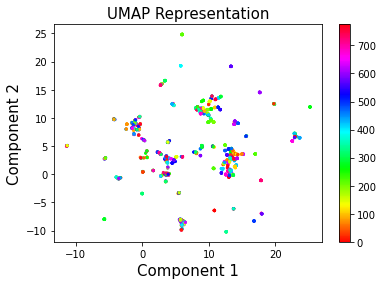

In [44]:
#We then graph, using col as the coloring key and hsv as the colormap (more colormaps here:
#https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html).
scatter(u[:,0],u[:,1],s=5,c=col,cmap="hsv")
#scatter(u[:,0],u[:,1],s=ncol,c=ncol,cmap="tab20c")
colorbar()
title("UMAP Representation",fontsize=15)
xlabel("Component 1",fontsize=15)
ylabel("Component 2",fontsize=15)
figsize(10,10)

In [45]:
#We can try also the plotnine package. For plotting there we need a pandas matrix. So we load pandas.
import pandas as pd
#We convert the u data frame, with the umap coordinates, to a dataframe.
df=pd.DataFrame(u,columns=["Coord1","Coord2"])
#We can add col as an additional column.
df['Bioproj']=col

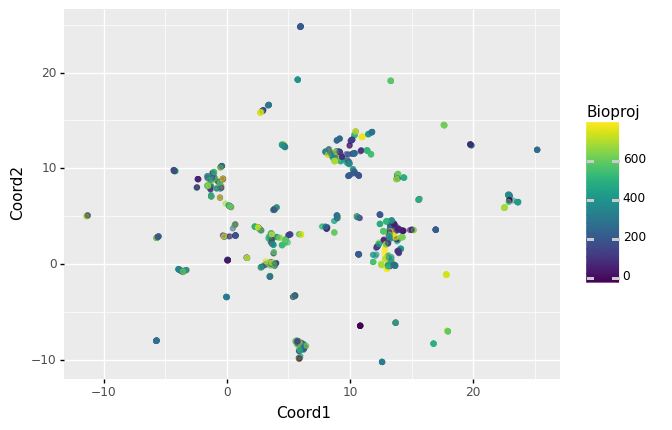

<ggplot: (179509194804)>

In [46]:
#We graph. Note that since col is added as a column of integers plotnine graphs using a continuous colormap.
from plotnine import *

(ggplot(df, aes(x='Coord1', y='Coord2', color='Bioproj')) +
        geom_point(alpha = 0.5)
)

In [57]:
#We can also color using the coloring scheme generated with change_col. For that we add ncolForPlotNine as the 
#third column of the data frame.
import pandas as pd

df=pd.DataFrame(u,columns=["Coord1","Coord2"])
df['Terms']=ncolForPlotNine

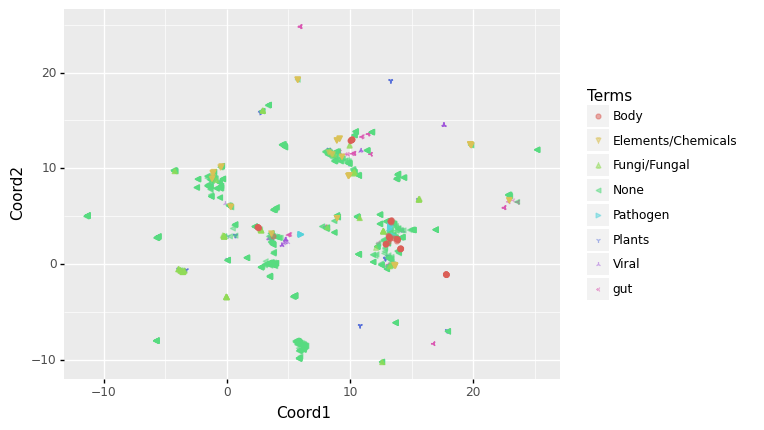

<ggplot: (179509516111)>

In [58]:
#Since ncolForPlotNine is a list of strings (as it contains the terms), the coloring is done discretely (as opposed
#to continuously). 
from plotnine import *

#In this case we also use ncolForPlotNine (Terms column) to set the shape of the dots. scale_shape_manual is used
#to give a list of shapes for plotnine to assign to the different dots. 
(ggplot(df, aes(x='Coord1', y='Coord2', color='Terms', shape='Terms')) +
        geom_point(alpha = 0.5) +
 scale_shape_manual(values=asarray(["o","v","^","<",">","1","2","3","4","8","s","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",1,2,3,4,5]))
)

#### dbSCAN

In [49]:
#We can also try clustering algorithms and then visualize the clusters. If we want to visualize only some clusters,
#filterGroups can generate a coloring scheme in which only the indicated clusters (identified by their number)
#are shown and the rest have the same color number assigned. colList is the list of said clusters to be shown
#and OrigCol the original ordered list of cluster per sample.

#NOTE THAT THE SPATIAL DISPOSITION OF THE DOTS IN THE PLOTS IS STILL GIVEN BY UMAP. Here we're with DBSCAN we're 
#doing a clusterization, not a bidimensional representation of the distances, as umap does.
#no
def filterGroups(colList,OrigCol):
    NewCol=[]
    for i in OrigCol:
        if i in colList:
            NewCol.append(str(i))
        else:
            NewCol.append(str(-1))
    return NewCol


In [50]:
#First we try DBSCAN as a clustering mechanism. The parameters were tuned based on what's shown in the notebook
#Scatterplot-ClusteringTuning. Again we set the distance metric as precomputed.
from sklearn.cluster import DBSCAN
#dbg is the object resulting from the clusterization. dbg.labels_ is an ordered list with the cluster that each
#sample belongs to.
dbg=DBSCAN(eps=0.1,metric="precomputed",min_samples=10).fit(distances)

In [51]:
#For matplotlib it can be useful to set the cluster numbers as apart as possible so that the colormap gives them
#distinct colors. This is done here and the result is saved in dbscanCols.
dbscanCols=[]
for i in dbg.labels_:
    if i==-1:
        dbscanCols.append(0)
    elif i==0:
        dbscanCols.append(25*10)
    else:
        if (i+1)%2==0:
            dbscanCols.append((i+1)*10)
        else:
            dbscanCols.append((i+1)*-10)

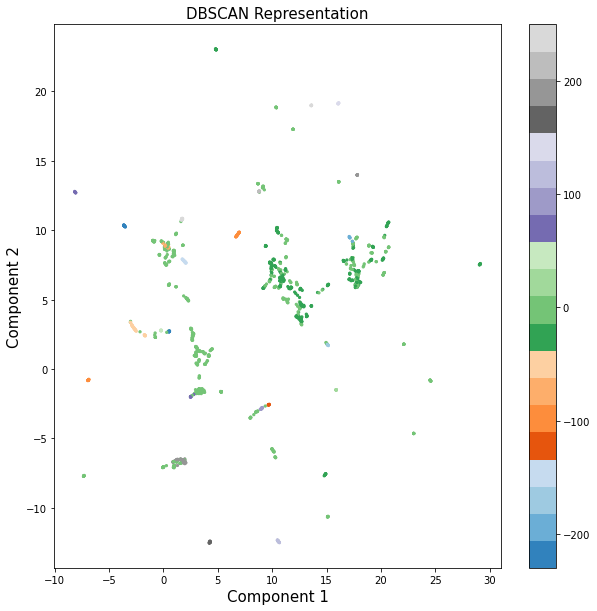

In [56]:
#We first plot using matplotlib, with dbscanCols as color scheme and tab20c as colormap.
scatter(u[:,0],u[:,1],s=5,c=dbscanCols,cmap="tab20c")
colorbar()
title("DBSCAN Representation",fontsize=15)
xlabel("Component 1",fontsize=15)
ylabel("Component 2",fontsize=15)
figsize(20,10)

In [57]:
#If we want to run DBSCAN with different parameters for plotnine it can be done here.
from sklearn.cluster import DBSCAN
dbg=DBSCAN(eps=0.1,metric="precomputed",min_samples=10).fit(distances)

In [92]:
#For plotnine we generate the pandas dataframe.
import pandas as pd

dfDBSC=pd.DataFrame(u,columns=["Coord1","Coord2"])
#We save the cluster number as a string so that coloring is done in a discrete fashion.
strLabels=[str(x) for x in list(dbg.labels_)]
#dfDBSC['Clusters']=dbg.labels_
dfDBSC['Clusters']=strLabels
#filterGroups can be used here if necessary to only see specific clusters.
#dfDBSC['Clusters']=filterGroups([2,3],dbg.labels_)

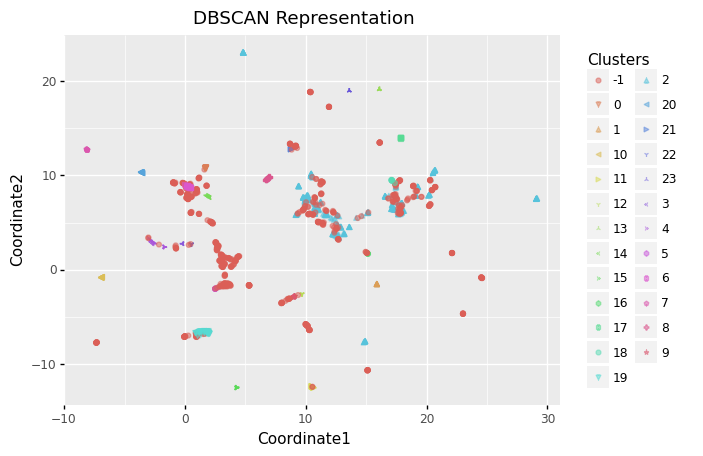

<ggplot: (164497432953)>

In [93]:
#Now we graph, same way as we did before.
from plotnine import *

(ggplot(dfDBSC, aes(x='Coord1', y='Coord2', color='Clusters', shape='Clusters')) +
        geom_point(alpha = 0.5) + labs(title="DBSCAN Representation", x="Coordinate1", y="Coordinate2") + 
 scale_shape_manual(values=asarray(["o","v","^","<",">","1","2","3","4","8","s","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",1,2,3,4,5]))
)

#### hdbSCAN

In [60]:
#We can also try HDBSCAN, a variation of DBSCAN, and run the same analyses for a comparison. 
import hdbscan
hdbg=hdbscan.HDBSCAN(eps=0.1,metric="precomputed",min_samples=10)
cluster_labels = hdbg.fit_predict(distances)

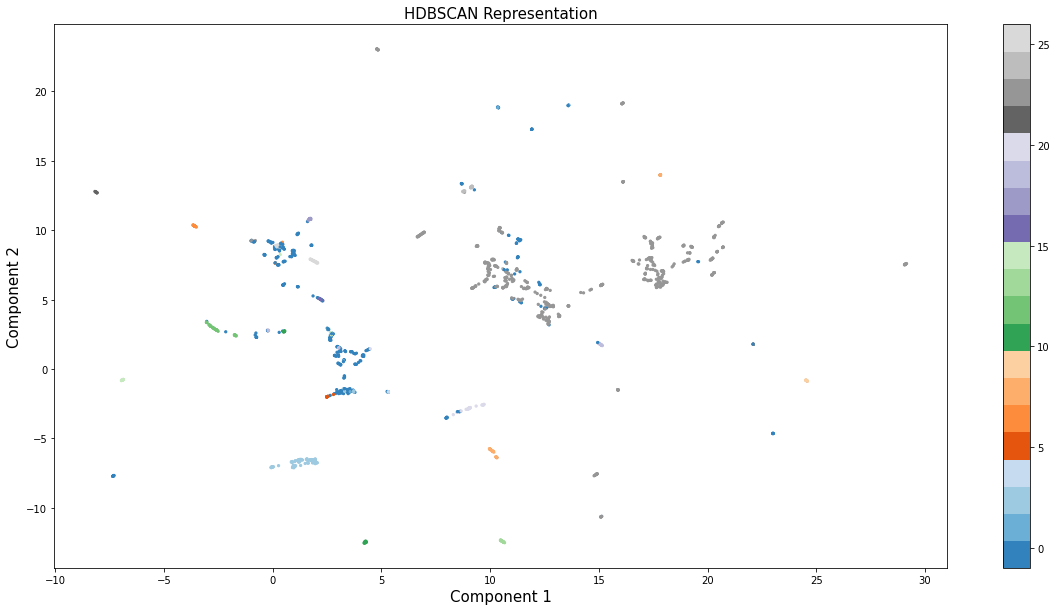

In [61]:
#We first graph using matplotlib with the same parameters as DBSCAN.
scatter(u[:,0],u[:,1],s=5,c=cluster_labels,cmap="tab20c")
colorbar()
title("HDBSCAN Representation",fontsize=15)
xlabel("Component 1",fontsize=15)
ylabel("Component 2",fontsize=15)
figsize(20,10)

In [62]:
#Again, we can run HDBSCAN here if we want to change something before plotting with plotnine.
import hdbscan
hdbg=hdbscan.HDBSCAN(eps=0.1,metric="precomputed",min_samples=10)
cluster_labels = hdbg.fit_predict(distances)

In [63]:
#We generate the pandas dataframe for plotnine.
import pandas as pd

dfHDBSC=pd.DataFrame(u,columns=["Coord1","Coord2"])
dfHDBSC['Clusters']=[str(x) for x in list(cluster_labels)]
#dfHDBSC['Clusters']=filterGroups([2,3,4,5,6],cluster_labels)

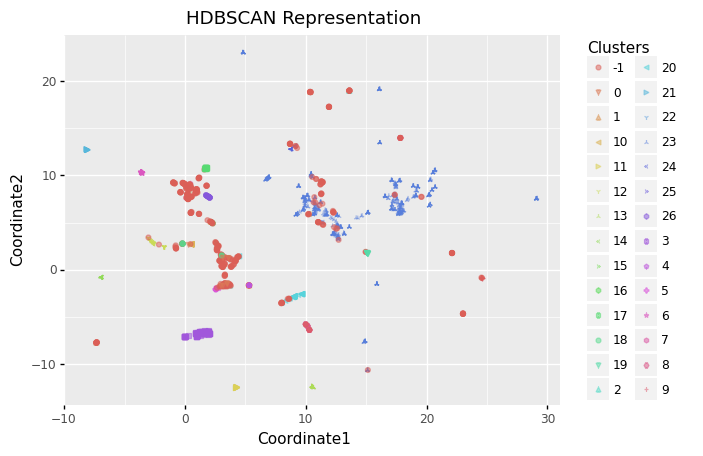

<ggplot: (164496857685)>

In [64]:
#We now do the graphing, again setting a group of possible shapes for the cluster samples to take.
from plotnine import *

(ggplot(dfHDBSC, aes(x='Coord1', y='Coord2', color='Clusters', shape='Clusters')) +
        geom_point(alpha = 0.5) + labs(title="HDBSCAN Representation", x="Coordinate1", y="Coordinate2") + 
 scale_shape_manual(values=asarray(["o","v","^","<",">","1","2","3","4","8","s","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",1,2,3,4]),expand=(1,0))
)

### Test for Keyword/MeSH Enrichment in Clusters

Now that we did some clustering of the samples we can look for enriched MeSH terms or keyword within the clusters generated, This will give us a better idea of what types of samples make up each cluster.

Here we'll only consider sample abundance, as clusters are made up of a consistent and unique set of samples (but that does not necessarily mean that all samples from a given bioproject are present in the same cluster).

#### Major MeSH and Keywords

In [65]:
#We will first define a function which computes the number of samples a term is in. It takes the term and the 
#term dictionary as parameters.
def TotalTermAbundance(term,termDict):
    this_projects=termDict[term]
#It then simply gets the bioprojects which contain the term, and uses col to identify which samples are associated to
#those bioprojects. The number of samples the term is is saved in total, and the latter is returned by the function.
    total=0
    for i in this_projects:
        total+=col.count(projects.index(i))
    return total

In [66]:
#The next function, getSigTerms, will determine which terms are significantly enriched in each cluster. This will be
#done using binomial tests with a bonferroni corrections. 
from scipy.stats import binom_test

#We need as parameters a list with the clusters, the dictionary of terms, and the ordered bioproject and term lists.
def getSigTerms(clusters,TermDict,ProjList,TermList):
#First thing we do is determine which samples are associated to each of the clusters. 
#First we get the number of clusters in total. We have to consider the 0-index in python and the fact that DBSCAN and
#HDBSCAN group all samples which were not confidently associated to a cluster in the -1 group (so this can be seen
#as a misc cluster).
    clustersPos=[]
#We sum a one whenever we make reference to a cluster as working with -1 as an index does not work (Python takes
#it as a reference to the last position). So for the purposes of the function cluster -1 will be treated as cluster
#0, cluster 0 as cluster 1, and so on.
    numClusters=max(clusters)-min(clusters)+1
    for i in range(numClusters):
        clustersPos.append([])
#We go through the list of cluster per sample. If the ith sample is associaed to the nth cluster, we save i in
#the nth list of clustersPos.
    for i in range(len(clusters)):
        clustersPos[(clusters[i]+1)].append(i)

#Now we move on to check which terms are present in each cluster .
    clust=0
    AllClusterTerms=[]
#We cycle through the clusters, look at the bioproject associated to each sample in the cluster, and add the words
#associated to it to the pool of words in the sample (clusterTerms). We end up then with a list of lists with all
#the term for each cluster.
    while clust<=(max(clusters)+1):
        ClusterTerms=[]
        for member in clustersPos[clust]:
            this_proj=projects[col[member]]
            try:
                for term in TermList[ProjList.index(this_proj)]:
                
                    if term not in ClusterTerms:
                        ClusterTerms.append(term)
            except: 
                pass
        AllClusterTerms.append(ClusterTerms)
        clust+=1

#We'll make as many binomial tests as there are terms present in each cluster. So we compute the number of 
#terms in total to be evaluated here.
    bonfCorrect=0
    for j in AllClusterTerms:
        bonfCorrect+=len(j)

#Now we do a final cycle through the list of lists with the terms per cluster to perform the binomial test.
    clust=0
    EnrichedAll={}
    SizeAll={}
    while clust<=(max(clusters)+1):
#For each term per cluster, we determine how many samples have bioprojects associated to that term, which yields the
#amount of time that term occurs in the cluster.
        EnrichedThis=[]
        SizeThis={}
        for term in AllClusterTerms[clust]:
            amount=0
            for member in clustersPos[clust]:
                if projects[col[member]] in TermDict[term]:
                    amount+=1
#We then carry out a binomial test. The null hypothesis is that the fraction of samples that have the term inside the
#cluster is equal to the fraction of samples which have it in the overall dataset. To get the fraction in the 
#dataset we use the function TotalTermAbundance from the cell above to get the abundance in the dataset and divide
#by the lenght of col.
            binomial=binom_test(x=amount, n=len(clustersPos[clust]),p=TotalTermAbundance(term,TermDict)/len(col))
#When we have the p-value we set 0.01 as the initial threshold of significance and perform the bonferroni correction.
            if binomial<0.01/(2*bonfCorrect):
#Terms which are significantly enriched (and also depleted) in a cluster are saved in the EnrichedThis list, and their
#abundance in the cluster in the SizeThis list.
                EnrichedThis.append(term)
                SizeThis[term]=amount
#After checking all terms in a cluster the lists generated just above are saved in dictionaries, which map cluster
#number (the original cluster numbers) to enriched/depleted terms and to their abundance. 
        realClust=clust-1
        EnrichedAll[realClust]=EnrichedThis
        SizeAll[realClust]=SizeThis
        clust+=1
    
    return EnrichedAll,SizeAll

In [76]:
#We run the function above for DBSCAN with keywords and major MeSH terms and print the results.
enrichedKeywords,sizeKey=getSigTerms(dbg.labels_,kwordtoProj,ProjforKeywords,keywords)
enrichedMajMeSH,sizeMahMeSH=getSigTerms(dbg.labels_,MajMeSHtoProj,ProjforMeSH,MesHMaj)

print("DBSCAN")
print("Cluster"+"\t"+"Term"+"\t"+"Type"+"\t"+"Abundance"+"\t"+"Cluster_Size"+"\t"+"Total Abundance")

clusters=max(dbg.labels_)-min(dbg.labels_)+1
for i in range(-1,clusters):
    Pos=i+1
    try:
#We use TotalTermAbundance to determine the total abundance in the dataset of the terms.
        for term in enrichedKeywords[i]:
            print(str(i)+"\t"+term+"\t"+"Keyword"+"\t"+str(sizeKey[i][term])+"\t"+str(list(dbg.labels_).count(i))+"\t"+str(TotalTermAbundance(term,kwordtoProj))+"\n")
    except KeyError:
        pass
    try:
        for term in enrichedMajMeSH[i]:
            print(str(i)+"\t"+term+"\t"+"MeSH"+"\t"+str(sizeMahMeSH[i][term])+"\t"+str(list(dbg.labels_).count(i))+"\t"+str(TotalTermAbundance(term,MajMeSHtoProj))+"\n")
    except KeyError:
        pass

DBSCAN
Cluster	Term	Type	Abundance	Cluster_Size	Total Abundance
-1	seawater metagenome	Keyword	78	769	87

-1	sorted cell/s	Keyword	62	769	62

-1	endophytes	Keyword	1	769	33

-1	Microbiota	MeSH	21	769	108

0	unclassified sequences	Keyword	18	20	493

0	ecological metagenomes	Keyword	18	20	339

0	lake water metagenome	Keyword	18	20	33

0	Metagenome	Keyword	18	20	542

1	tissue sample	Keyword	11	11	11

1	fecal sample	Keyword	11	11	25

1	crc mice	Keyword	11	11	11

1	unclassified sequences	Keyword	11	11	493

1	mouse gut metagenome	Keyword	11	11	18

1	crc	Keyword	11	11	19

1	fecal samples	Keyword	11	11	25

2	diversity	Keyword	118	407	239

2	16S	Keyword	136	407	254

2	Microbiota	Keyword	132	407	324

2	metabolism	Keyword	41	407	73

2	Gut	Keyword	57	407	96

2	illumina miseq sequencing	Keyword	16	407	16

2	oral samples	Keyword	16	407	16

2	Animals	MeSH	65	407	101

2	Microbiota	MeSH	64	407	108

2	Humans	MeSH	38	407	46

2	Mice	MeSH	20	407	22

2	DNA, Bacterial	MeSH	16	407	16

2	Female	MeSH	30	407	39


In [69]:
#Here we do the same as above but employing the output of HDBSCAN.
enrichedKeywords,sizeKey=getSigTerms(cluster_labels,kwordtoProj,ProjforKeywords,keywords)
enrichedMajMeSH,sizeMahMeSH=getSigTerms(cluster_labels,MajMeSHtoProj,ProjforMeSH,MesHMaj)

print("Cluster"+"\t"+"Term"+"\t"+"Type"+"\t"+"Abundance"+"\t"+"Cluster_Size"+"\t"+"Total Abundance")

print("HDBSCAN")
clusters=max(cluster_labels)-min(cluster_labels)+1
for i in range(-1,clusters):
    Pos=i+1
    try:
        for term in enrichedKeywords[i]:
            print(str(i)+"\t"+term+"\t"+"Keyword"+"\t"+str(sizeKey[i][term])+"\t"+str(list(cluster_labels).count(i))+"\t"+str(TotalTermAbundance(term,kwordtoProj))+"\n")
    except KeyError:
        pass
    try:
        for term in enrichedMajMeSH[i]:
            print(str(i)+"\t"+term+"\t"+"MeSH"+"\t"+str(sizeMahMeSH[i][term])+"\t"+str(list(cluster_labels).count(i))+"\t"+str(TotalTermAbundance(term,MajMeSHtoProj))+"\n")
    except KeyError:
        pass

Cluster	Term	Type	Abundance	Cluster_Size	Total Abundance
HDBSCAN
-1	metagenomic	Keyword	55	431	93

-1	16S	Keyword	28	431	254

-1	seawater metagenome	Keyword	63	431	87

-1	peat metagenome	Keyword	24	431	29

-1	sorted cell/s	Keyword	53	431	62

-1	uncultured microbe	Keyword	23	431	26

-1	Microbiota	MeSH	6	431	108

2	sorted cell/s	Keyword	5	7	62

3	enriched cells	Keyword	57	107	78

3	coal metagenome	Keyword	107	107	130

3	powder river basin	Keyword	57	107	76

3	coal bed	Keyword	73	107	90

3	ecological metagenomes	Keyword	50	107	339

4	sediment metagenome	Keyword	6	7	54

5	water microbiology	Keyword	12	12	27

5	deep sea	Keyword	6	12	8

6	enriched cells	Keyword	21	24	78

6	coal metagenome	Keyword	23	24	130

6	powder river basin	Keyword	19	24	76

6	coal bed	Keyword	17	24	90

8	root endosphere	Keyword	8	33	9

8	greenhouse	Keyword	8	33	21

8	rhizosphere metagenome	Keyword	8	33	27

8	biogeochemical cycling	Keyword	4	33	5

8	carrion	Keyword	4	33	5

8	detritus	Keyword	4	33	5

8	carcass	Keyword	4	3

#### Minor MeSH

In [55]:
#For MinorMeSH we'll define a very similar function as for keywords and Major MeSH. In fact, TotalTermAbundance is
#defind in exactly the same way.
def TotalTermAbundance(term,termDict):
    this_projects=termDict[term]
    total=0
    for i in this_projects:
        total+=col.count(projects.index(i))
    return total

In [73]:
#The new function is called getSigTermsMinorMesH and does exactly the same as getSigTerms, so comments are only
#added where differencea are found.
from scipy.stats import binom_test

#As parameter we'll need both the Major MeSH term ordered list and the Minor MeSH ordere list.
def getSigTermsMinorMesH(clusters,TermDict,ProjList,TermList,MajTermList):
    clustersPos=[]
    numClusters=max(clusters)-min(clusters)+1
    for i in range(numClusters):
        clustersPos.append([])
    for i in range(len(clusters)):
        clustersPos[(clusters[i]+1)].append(i)
    
    clust=0
    AllClusterTerms=[]
    while clust<=(max(clusters)+1):
        ClusterTerms=[]
        for member in clustersPos[clust]:
            this_proj=projects[col[member]]
            try:
#The difference lies in the fact that we need to generate the full MeSH Term (major + minor terms) and then work
#with those to determine abundance and run the statistical tests. Hence, here the complete MeSh term is constructed
#using the major MeSH term and minor MeSH term.
                for z in range(len(MajTermList[ProjList.index(this_proj)])):
                    for term in TermList[ProjList.index(this_proj)][z]:
                        FullTerm=MajTermList[ProjList.index(this_proj)][z]+"_"+term
                        if FullTerm not in ClusterTerms:
                            ClusterTerms.append(FullTerm)
            except ValueError: 
                pass
        AllClusterTerms.append(ClusterTerms)
        clust+=1
    bonfCorrect=0
    for j in AllClusterTerms:
        bonfCorrect+=len(j)
    
    clust=0
    EnrichedAll={}
    SizeAll={}
    while clust<=(max(clusters)+1):
        EnrichedThis=[]
        SizeThis={}
        for term in AllClusterTerms[clust]:
            amount=0
            for member in clustersPos[clust]:
                if projects[col[member]] in TermDict[term]:
                    amount+=1
            binomial=binom_test(x=amount, n=len(clustersPos[clust]),p=TotalTermAbundance(term,TermDict)/len(col))
            if binomial<0.01/(2*bonfCorrect):
                EnrichedThis.append(term)
                SizeThis[term]=amount
        realClust=clust-1
        EnrichedAll[realClust]=EnrichedThis
        SizeAll[realClust]=SizeThis
        clust+=1
    
    return EnrichedAll,SizeAll

In [74]:
#We generate a table of all of the enriched/depleted minor MeSH terms with DBSCAN.
enrichedMinMeSH,sizeMinMeSH=getSigTermsMinorMesH(dbg.labels_,MinMeSHtoProj,ProjforMeSH,MesHMin,MesHMaj) 

print("DBSCAN")
print("Cluster"+"\t"+"Term"+"\t"+"Type"+"\t"+"Abundance"+"\t"+"Cluster_Size"+"\t"+"Total Abundance")

clusters=max(dbg.labels_)-min(dbg.labels_)+1
for i in range(-1,clusters):
    Pos=i+1
    try:
        try:
            for term in enrichedMinMeSH[i]:
                print(str(i)+"\t"+term+"\t"+"MinMeSH"+"\t"+str(sizeMinMeSH[i][term])+"\t"+str(list(dbg.labels_).count(i))+"\t"+str(TotalTermAbundance(term,MinMeSHtoProj))+"\n")
        except KeyError:
            continue
    except ValueError:
        pass

DBSCAN
Cluster	Term	Type	Abundance	Cluster_Size	Total Abundance
2	Bacteria_genetics	MinMeSH	18	407	19

2	DNA, Bacterial_genetics	MinMeSH	16	407	16

2	RNA, Ribosomal, 16S_genetics	MinMeSH	39	407	52

2	Microbiota_genetics	MinMeSH	32	407	38

12	Phosphorus_analysis	MinMeSH	10	10	16

12	Waste Disposal, Fluid_methods	MinMeSH	10	10	19

12	Waste Water_chemistry	MinMeSH	10	10	10

12	Water Pollutants, Chemical_analysis	MinMeSH	10	10	16

13	Ammonia_metabolism	MinMeSH	12	12	12

13	Ammonia_pharmacology	MinMeSH	12	12	12

13	Bacteria_classification	MinMeSH	12	12	44

13	Bacteria_drug effects	MinMeSH	12	12	12

13	Bacteria_isolation &amp	MinMeSH	12	12	37

13	Bacteria_ purification	MinMeSH	12	12	37

13	Bacteria_metabolism	MinMeSH	12	12	23

13	Nitrites_metabolism	MinMeSH	12	12	12

13	Nitrites_pharmacology	MinMeSH	12	12	12



In [75]:
#And one with HDBSCAN.
enrichedMinMeSH,sizeMinMeSH=getSigTermsMinorMesH(cluster_labels,MinMeSHtoProj,ProjforMeSH,MesHMin,MesHMaj) 

print("HDBSCAN")
print("Cluster"+"\t"+"Term"+"\t"+"Type"+"\t"+"Abundance"+"\t"+"Cluster_Size"+"\t"+"Total Abundance")

clusters=max(cluster_labels)-min(cluster_labels)+1
for i in range(-1,clusters):
    Pos=i+1
    try:
        for term in enrichedMinMeSH[i]:
            print(str(i)+"\t"+term+"\t"+"MinMeSH"+"\t"+str(sizeMinMeSH[i][term])+"\t"+str(list(cluster_labels).count(i))+"\t"+str(TotalTermAbundance(term,MinMeSHtoProj))+"\n")
    except ValueError:
        pass

HDBSCAN
Cluster	Term	Type	Abundance	Cluster_Size	Total Abundance
9	Plankton_growth &amp	MinMeSH	4	10	6

9	Plankton_ development	MinMeSH	4	10	6

9	Ponds_microbiology	MinMeSH	4	10	6

20	Phosphorus_analysis	MinMeSH	10	37	16

20	Waste Disposal, Fluid_methods	MinMeSH	10	37	19

20	Waste Water_chemistry	MinMeSH	10	37	10

20	Water Pollutants, Chemical_analysis	MinMeSH	10	37	16

23	Bacteria_classification	MinMeSH	41	652	44

23	Bacteria_isolation &amp	MinMeSH	34	652	37

23	Bacteria_ purification	MinMeSH	34	652	37

23	RNA, Ribosomal, 16S_genetics	MinMeSH	48	652	52

23	Microbiota_genetics	MinMeSH	35	652	38



KeyError: 27

## Distance Analyses

After doing the clustering analyses the last remaining one is to analyse the MASH distance distribution of the samples based on some grouping of them. This will be done for comparison of intraproject vs interproject distances, and for analysis of significant clustering of samples associated to a given term.

#### Mash Distance Analysis (All BioProjects)

In [29]:
#We begin by comparing the distribution of distance of samples in the same bioproject (intraproject) vs samples in 
#different bioprojects (interproject).

#For that we go through the list col. If two numbers are equal in that list, then the samples associated to those
#positions come from the same bioproject. Otherwise they come from a different one.
group_distances=[]
diff_distances=[]

#We cycle through the distances matrix. col and distances have the same sample order. For each sample we do an 
#internal cycle with the pairs of samples (not considered yet) which include that sample. If they have the same
#number in col we save the distance in group_distances. Otherwise we save it in diff_distances.
for i in range(1,distances.shape[0]):
    for j in range(0,i):
        if col[i]==col[j]:
#Remove comments here if the position of the samples with the same bioproject but distance of 1 (max distance) 
#should be printed.
            #if distances[i,j]==1.0:
                #print(i)
                #print(j)
                #print("===")
            group_distances.append(distances[i,j])
        else:
#Remove comments here if the position of the samples with different bioproject but distance of 0 (min distance) 
#should be printed.
            #if distances[i,j]<0.1:
                #print(i)
                #print(j)
                #print("===")
            diff_distances.append(distances[i,j])

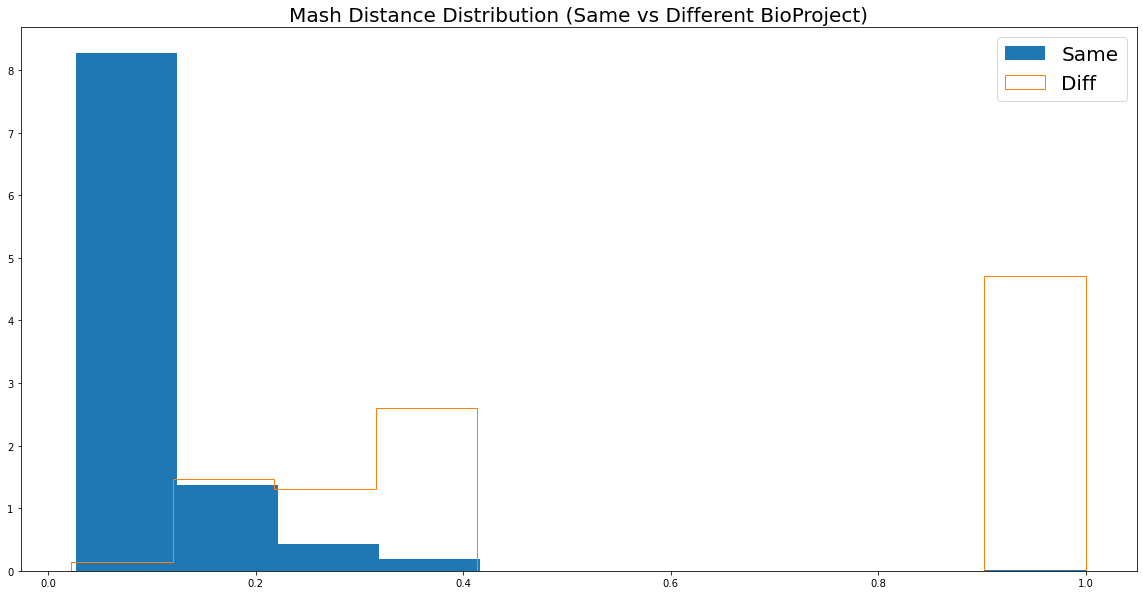

In [30]:
#Now we plot a histogram with the distribution of inter and intraproject distances.
hist(group_distances,histtype='bar',label="Same", density=True)
hist(diff_distances,histtype='step',label="Diff", density=True)
title("Mash Distance Distribution (Same vs Different BioProject)", fontsize=20)
legend(prop={'size': 20})

In [31]:
#We compare the distances statistically using a Wilcoxon RankSum and a Kolmogorov-Smirnov test. An aleatorization
#could also be done (but for now I leave it like this). Note that here we're comparing the distributions and their
#mediands.
from scipy.stats import ranksums,kstest

print(ranksums(group_distances,diff_distances))

print(kstest(group_distances,diff_distances))

RanksumsResult(statistic=-98.18862897166156, pvalue=0.0)
KstestResult(statistic=0.8368871504545193, pvalue=0.0)


#### Mash Distance Analysis (Keywords/MeSH Terms)

In [61]:
#Next we can do is do a similar analysis but with comparing the distances of samples which harbor specific terms
#as opposed to those which do not.

#First thing to do is determine the distances for each group (terms with the samples vs terms without the samples).
group_distances=[]
diff_distances=[]

#The procedure is the same as above but we'll use ncol instead of col. The only change in the code is that we do not
#consider samples without the term as samples in the same group (and as such their distances are saved in diff_distances
#and not in group_distances).
for i in range(1,distances.shape[0]):
    for j in range(0,i):
        if ncol[i]==ncol[j] and ncol[i]!=2:
            #if distances[i,j]==1.0:
                #print(i)
                #print(j)
                #print("===")
            group_distances.append(distances[i,j])
        else:
            #if distances[i,j]<0.1:
                #print(i)
                #print(j)
                #print("===")
            diff_distances.append(distances[i,j])

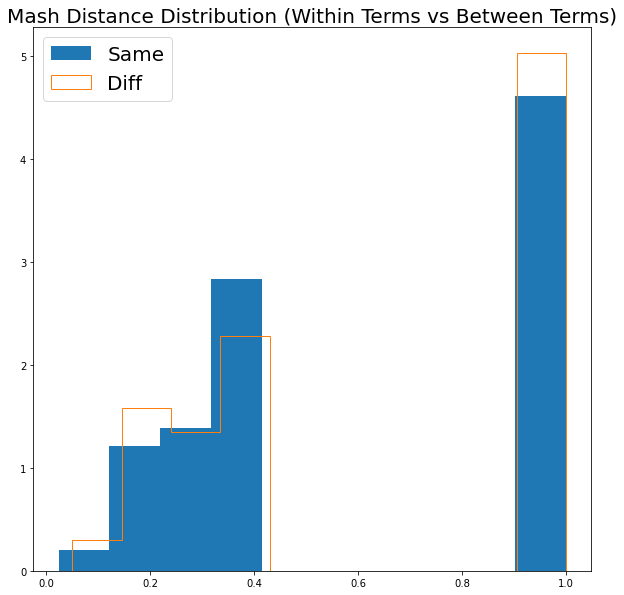

In [35]:
#We plot the distances as histograms here.
hist(group_distances,histtype='bar',label="Same", density=True)
hist(diff_distances,histtype='step',label="Diff", density=True)
title("Mash Distance Distribution (Within Terms vs Between Terms)", fontsize=20)
legend(prop={'size': 20})

In [36]:
#Again we compare with the Wilcoxon and Kolmogovor-Smirnov text.
from scipy.stats import ranksums,kstest

print(ranksums(group_distances,diff_distances))

print(kstest(group_distances,diff_distances))

RanksumsResult(statistic=-11.084708783413681, pvalue=1.4883393170118953e-28)
KstestResult(statistic=0.027448891609998527, pvalue=8.373346230555058e-71)


#### Test for Significant Differences in Clustering for Keywords

In [62]:
#Now we can do a more individualized and comprehensive test for each of the keywords. We'll consider each keyword 
#individually and perform three tests. 
import statistics 
import random
import copy

#One of the tests is going to be an aleatorization analysis. For that we'll define a function to perform an 
#aleatorizations. We'll need the distance matrix (dist), the number of times the aleatorization should take place
#(times) and the labels of the groups (labels).
def aleatorizationForTerms(dist,times,labels):
    differences=[]
    newlabels=copy.deepcopy(labels)
#What we do is shuffle the list of labels the number of times indicated by times.
    for i in range(0,times):
        random.shuffle(newlabels)
        group_distances=[]
        diff_distances=[]
#With the shuffling done we get the distances of samples with the term and without the term.
        for i in range(1,dist.shape[0]):
            for j in range(0,i):
                if newlabels[i]==20 and newlabels[j]==20:
                    group_distances.append(dist[i,j])
                elif newlabels[i]==2 and newlabels[j]==2:
                    diff_distances.append(dist[i,j])
#We compute each tieme the difference of the medians of the distance of both groups (with the term and without it) 
#based on the labels.
        differences.append(statistics.median(diff_distances)-statistics.median(group_distances))
#At the end the function returns a list with all the results of this median difference.
    differences.sort()
    return differences

In [74]:
#Now we do the tests themselves. We'll do the same two tests done in the previous analyses (Wilcoxon and Kolmogorov-
#Smirnov) apart from the aleatorization. 
from scipy.stats import ranksums,kstest
significant=[]
abSignificant=[]
abundance=[]

#Running aleatorizations for all the keywords would be particularly costly computationally, so we establish an 
#abundance cut. This cut can be set based on the overall abundance of keywords per projects or samples. 
#A histogram of the abundance in bioprojects or samples of the keywords is shown below.
byProj=0

for term in kwordtoProj.keys():
#If we'll work with the abundance by bioproject then we set byProj=1 and estimate abundances based on this.
#If we set byProj=0 then we count abundances by sample and filter using samples. Note that regardless of this
#the distance analysis is always done using samples.

#The default cut is 5, but this can be changed here. The list abundances will save the abundance of all keywords
#in terms of samples or bioprojects.
    if byProj==1:
        abundance.append(len(kwordtoProj[term]))
        if len(kwordtoProj[term])<5:
            continue
        ncol,thisColMap,Wol=change_col(kwordtoProj,[term],0)
    else:
        ncol,thisColMap,Wol=change_col(kwordtoProj,[term],0)
        abundance.append(ncol.count(20))
        if abundance[-1]>25 or abundance[-1]<20:
            continue
    print(term)

#For each term we get the distances of samples which have the keyword or don't as we've done before.
    group_distances=[]
    diff_distances=[]
    for i in range(1,distances.shape[0]):
        for j in range(0,i):
            if ncol[i]==20  and ncol[j]==20:
                group_distances.append(distances[i,j])
            elif ncol[i]==2  and ncol[j]==2:
                diff_distances.append(distances[i,j])

#We then move on to carry out the three tests. First the Wilcoxon and Kolmogorov-Smirnov.
    a,b=ranksums(group_distances,diff_distances)
    c,d=kstest(group_distances,diff_distances)
#Then we get the real difference of medians between samples with the same term and different terms.
    actual_diff=statistics.median(diff_distances)-statistics.median(group_distances)
    #After that we get the result of the aleatorization and compare with the median distribution.
    Randdiff=aleatorizationForTerms(distances,10,ncol)
    SignPosLow=int((len(Randdiff)*0.01))
    SignPosHigh=int((len(Randdiff)*0.99))
#We compare the p-values of the first two tests (with bonferroni correction) and check the aleatorization. For the
#aleatorization we check if the distances is smaller than the 1% percentile of the random median distance distribution.
    if b<0.01/(2*len(kwordtoProj)) and d<0.01/(2*len(kwordtoProj)) and (Randdiff[SignPosLow]>actual_diff or Randdiff[SignPosHigh]<actual_diff):
#We print the terms which pass the criteria with their abundance
        if Randdiff[SignPosLow]>actual_diff:
            where="low"
        else:
            where="high"
        if byProj==1:
            abSignificant.append(len(kwordtoProj[term]))
            print(term+"\t"+str(len(kwordtoProj[term]))+"\t"+where)
        else:
            abSignificant.append(abundance[-1])  
            print(term+"\t"+str(abundance[-1])+"\t"+where)
        significant.append(term)

interproximal
interproximal	7
cicadas


KeyboardInterrupt: 

Text(0, 0.5, 'Frequency')

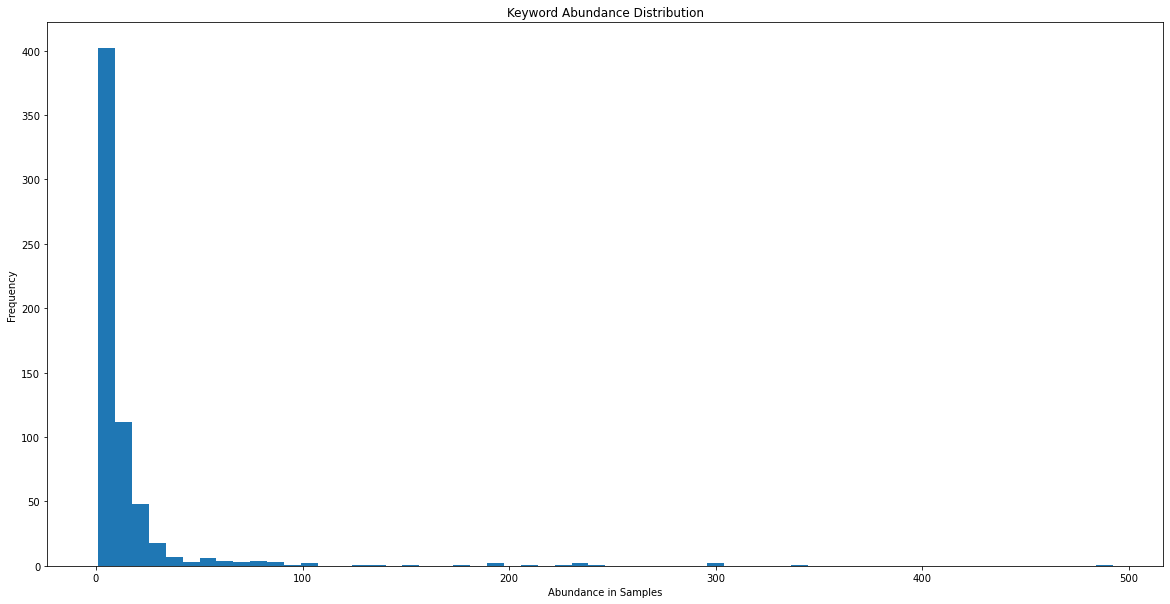

In [50]:
#We also graph the histogram of the abundance of keywords per sample or keywords (depending on the case).
hist(abundance,histtype='bar', density=False,bins=60,)
title("Keyword Abundance Distribution")
if byProj==1:
    xlabel("Abundance in Bioprojects")
else:
    xlabel("Abundance in Samples")
ylabel("Frequency")

In [76]:
#Now we run the same test but with MajorMeSH terms. The process is exactly the same, what changes are some variable
#names and the dictionary we're using. The comments are basically the same as above with minor changes.
from scipy.stats import ranksums,kstest
MeSHsignificant=[]
MeSHabSignificant=[]
MeSHabundance=[]

#Running aleatorizations for all the Major MeSH would be particularly costly computationally, so we establish an 
#abundance cut. This cut can be set based on the overall abundance of Major MeSH per projects or samples. 
#A histogram of the abundance in bioprojects or samples of the Major MeSH is shown below.
byProj=0

for term in MajMeSHtoProj.keys():
#If we'll work with the abundance by bioproject then we set byProj=1 and estimate abundances based on this.
#If we set byProj=0 then we count abundances by sample and filter using samples. Note that regardless of this
#the distance analysis is always done using samples.

#The default cut is 5, but this can be changed here. The list MeSHabundances will save the abundance of all Major MeSH
#in terms of samples or bioprojects.
    if byProj==1:
        MeSHabundance.append(len(MajMeSHtoProj[term]))
        if len(MajMeSHtoProj[term])<5:
            continue
        ncol,thisColMap,Wol=change_col(MajMeSHtoProj,[term],0)
    else:
        ncol,thisColMap,Wol=change_col(MajMeSHtoProj,[term],0)
        MeSHabundance.append(ncol.count(20))
        if MeSHabundance[-1]<5:
            continue
    print(term)

#For each term we get the distances of samples which have the Major MeSH or don't as we've done before.
    group_distances=[]
    diff_distances=[]

    for i in range(1,distances.shape[0]):
        for j in range(0,i):
            if ncol[i]==20 and ncol[j]==20:
                group_distances.append(distances[i,j])
            elif ncol[i]==2 and ncol[j]==2:
                diff_distances.append(distances[i,j])

#We then move on to carry out the three tests. First the Wilcoxon and Kolmogorov-Smirnov.
    a,b=ranksums(group_distances,diff_distances)
    c,d=kstest(group_distances,diff_distances)
#Then we get the real difference of medians between samples with the same term and different terms.
    actual_diff=statistics.median(diff_distances)-statistics.median(group_distances)
    #After that we get the result of the aleatorization and compare with the median distribution.
    Randdiff=aleatorizationForTerms(distances,1000,ncol)
    SignPosLow=int((len(Randdiff)*0.01))
    SignPosHigh=int((len(Randdiff)*0.99))
#We compare the p-values of the first two tests (with bonferroni correction) and check the aleatorization. For the
#aleatorization we check if the distances is smaller than the 1% percentile of the random median distance distribution.
    if b<0.01/(2*len(MajMeSHtoProj)) and d<0.01/(2*len(MajMeSHtoProj)) and (Randdiff[SignPosLow]>actual_diff or Randdiff[SignPosHigh]<actual_diff):
#We print the terms which pass the criteria with their abundance
        if Randdiff[SignPosLow]>actual_diff:
            where="low"
        else:
            where="high"
        if byProj==1:
            MeSHabSignificant.append(len(MeSHabSignificant[term]))
            print(term+"\t"+str(len(MajMeSHtoProj[term])))
        else:
            MeSHabSignificant.append(MeSHabundance[-1]) 
            print(term+"\t"+str(MeSHabundance[-1]))
        MeSHsignificant.append(term)

Animals
Ascomycota
Ascomycota	14
Biological Evolution
Biological Evolution	7
Aquaculture


KeyboardInterrupt: 

Text(0, 0.5, 'Frequency')

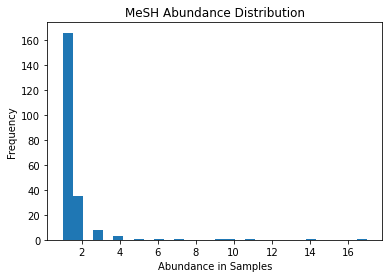

In [20]:
#We graph the histogram for Major MeSh abundance for bioprojects or samples.
hist(MeSHabundance,histtype='bar', density=False,bins=60,)
title("Major MeSH Abundance Distribution")
if byProj==1:
    xlabel("Abundance in Bioprojects")
else:
    xlabel("Abundance in Samples")
ylabel("Frequency")

In [77]:
#Now with Minor MeSH terms. 
from scipy.stats import ranksums,kstest
MinMeSHsignificant=[]
MinMeSHabSignificant=[]
MinMeSHabundance=[]

#Running aleatorizations for all the Minor MeSH would be particularly costly computationally, so we establish an 
#abundance cut. This cut can be set based on the overall abundance of Major MeSH per projects or samples. 
#A histogram of the abundance in bioprojects or samples of the Major MeSH is shown below.
byProj=0

for term in MinMeSHtoProj.keys():
#If we'll work with the abundance by bioproject then we set byProj=1 and estimate abundances based on this.
#If we set byProj=0 then we count abundances by sample and filter using samples. Note that regardless of this
#the distance analysis is always done using samples.

#The default cut is 5, but this can be changed here. The list MinMeSHabundance will save the abundance of all Minor 
#MeSH in terms of samples or bioprojects.
    if byProj==1:
        MinMeSHabundance.append(len(MinMeSHtoProj[term]))
        if len(MinMeSHtoProj[term])<5:
            continue
        ncol,thisColMap,Wol=change_col(MinMeSHtoProj,[term],0)
    else:
        ncol,thisColMap,Wol=change_col(MinMeSHtoProj,[term],0)
        MinMeSHabundance.append(ncol.count(20))
        if MinMeSHabundance[-1]<5:
            continue
    print(term)

#For each term we get the distances of samples which have the Major MeSH or don't as we've done before.
    group_distances=[]
    diff_distances=[]

    for i in range(1,distances.shape[0]):
        for j in range(0,i):
            if ncol[i]==20 and ncol[j]==20:
                group_distances.append(distances[i,j])
            elif ncol[i]==2 and ncol[j]==2:
                diff_distances.append(distances[i,j])

#We then move on to carry out the three tests. First the Wilcoxon and Kolmogorov-Smirnov.
    a,b=ranksums(group_distances,diff_distances)
    c,d=kstest(group_distances,diff_distances)
#Then we get the real difference of medians between samples with the same term and different terms.
    actual_diff=statistics.median(diff_distances)-statistics.median(group_distances)
    #After that we get the result of the aleatorization and compare with the median distribution.
    Randdiff=aleatorizationForTerms(distances,1000,ncol)
    SignPosLow=int((len(Randdiff)*0.01))
    SignPosHigh=int((len(Randdiff)*0.99))
#We compare the p-values of the first two tests (with bonferroni correction) and check the aleatorization. For the
#aleatorization we check if the distances is smaller than the 1% percentile of the random median distance distribution.
    if b<0.01/(2*len(MinMeSHtoProj)) and d<0.01/(2*len(MinMeSHtoProj)) and (Randdiff[SignPosLow]>actual_diff or Randdiff[SignPosHigh]<actual_diff):
#We print the terms which pass the criteria with their abundance.
        if Randdiff[SignPosLow]>actual_diff:
            where="low"
        else:
            where="high"
        if byProj==1:
            MinMeSHabSignificant.append(len(MinMeSHtoProj[term]))
            print(term+"\t"+str(len(MinMeSHtoProj[term])))
        else:
            MinMeSHabSignificant.append(MinMeSHabundance[-1]) 
            print(term+"\t"+str(MinMeSHabundance[-1]))
        MinMeSHsignificant.append(term)           

Ascomycota_metabolism
Ascomycota_metabolism	10
Bees_physiology


KeyboardInterrupt: 

In [ ]:
#We graph the histogram for Major MeSh abundance for bioprojects or samples.
hist(MinMeSHabundance,histtype='bar', density=False,bins=60,)
title("Minor MeSH Abundance Distribution")
if byProj==1:
    xlabel("Abundance in Bioprojects")
else:
    xlabel("Abundance in Samples")
ylabel("Frequency")

## Generate Metadata Table

The last thing that needs to be done is generate a table of the metadata of the samples. The idea is to generate a binary table of presence/absence of certain keywords and with all MajorMeSh and Minor terms. This can naturally be refined further as we move forward (e.g.: to filter MeSH terms).

In [45]:
#We first select the keywords which will go in the table. They will be saved in keyIn.
keyIn=[]
#For now with the keywords present in more than 4 samples it will suffice. But naturally this can be changed.
for i in kwordtoProj.keys():
    ncol,thisColMap,Wol=change_col(kwordtoProj,[i],0)
    count=ncol.count(20)
    if count>4:
        keyIn.append(i)

#This can be done also with abundance in projects. For now let's add both cases to the same list.
keyIn=[]
for i in kwordtoProj.keys():
    if len(kwordtoProj[i])>4:
        keyIn.append(i)

In [47]:
#Now we generate the table itself with the data. 
table=open("DraftMetadata.tab","w")
header="id;Project;SRR"
#First we add the keywords and the Major MeSH terms in the header.
for i in keyIn:
    header=header+"\t"+i
for j in MajMeSHtoProj:
    header=header+"\t"+j
table.write(header+"\n")

#For each sample we add the bioproject, and put a Yes if each keyword/MeSH is present in the sample, and a 
#No otherwise.
for i in range(len(ids)):
    line=str(ids[i])+"\t"+projects[col[i]]+"\t"+SRRs[col[i]]
    for z in keyIn:
        if projects[col[i]] in kwordtoProj[z]:
            line=line+"\t"+"Yes"
        else:
            line=line+"\t"+"No"
    for j in MajMeSHtoProj:
        if projects[col[i]] in MajMeSHtoProj[j]:
            line=line+"\t"+"Yes"
        else:
            line=line+"\t"+"No"
    for h in MinMeSHtoProj:
        if projects[col[i]] in MinMeSHtoProj[h]:
            line=line+"\t"+"Yes"
        else:
            line=line+"\t"+"No"
    table.write(line+"\n")
table.close()